In [1]:
import boto3
import argparse

In [2]:
def submit_job(lr:float, momentum:float, epochs:int, profile_name="default"):
    """
    Submit a job to AWS Batch queue.
    Parameters
    ----------
    lr: float
        Learning rate
    momentum: float
    epochs: float
        Maximum number of training epochs
    profile_name: str
        The profile name used to access AWS.
        The profile is defined in `~/.aws/credentials`.
        Default value is "default".
    """
    session = boto3.Session(profile_name=profile_name)
    client = session.client("batch")
    
    title = "lr" + str(lr).replace(".", "") + "_m" + str(momentum).replace(".", "")
    resp = client.submit_job(
        jobName=title,
        jobQueue="SimpleBatchjob-queue",
        jobDefinition="SimpleBatchjob-definition",
        containerOverrides={
            "command": ["python3", "main.py",
                        "--lr", str(lr),
                        "--momentum", str(momentum),
                        "--epochs", str(epochs),
                        "--uploadS3", "true"]
        }
    )
    print("Job submitted!")
    print("job name", resp["jobName"], "job ID", resp["jobId"])

### Let's submit a single job

In [3]:
submit_job(0.01, 0.1, 50, profile_name="kaguya")

Job submitted!
job name lr001_m01 job ID 9448f82b-0d29-4fdc-9ebe-e672f30848c5


### Let's download the learning result and make plots

In [2]:
import pandas as pd
import io
from matplotlib import pyplot as plt

In [3]:
def read_table_from_s3(key, profile_name="default"):
    session = boto3.Session(profile_name=profile_name)
    s3 = session.resource("s3")
    bucket = s3.Bucket("simplebatchbucket")
    
    obj = bucket.Object(key).get().get("Body")
    df = pd.read_csv(obj)
    
    return df

In [10]:
df = read_table_from_s3("metrics_lr0.0100_m0.1000.csv", profile_name="kaguya")

In [11]:
df

,train_loss,val_loss,val_accuracy
0,0.576256,0.228649,93.408333
1,0.306821,0.177331,94.566667
2,0.242569,0.141495,95.741667
3,0.205177,0.116622,96.575000
4,0.171432,0.101879,96.908333
...,...,...,...
95,0.010329,0.043034,98.950000
96,0.010587,0.045424,99.000000
97,0.010425,0.044859,98.991667
98,0.010533,0.043775,99.008333


Best loss: 0.2286491922140121
Best loss epoch: 0
Best accuracy: 99.05833333333334
Best accuracy epoch: 66


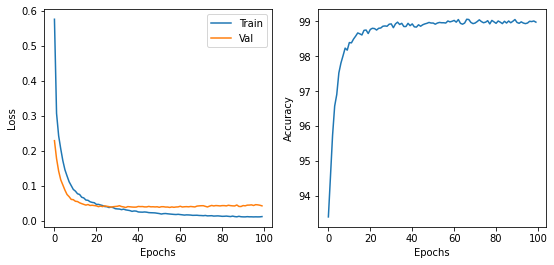

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))
x = [i for i in range(df.shape[0])]
ax1.plot(x, df["train_loss"], label="Train")
ax1.plot(x, df["val_loss"], label="Val")
ax2.plot(x, df["val_accuracy"])

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

print("Best loss:", df["val_loss"].max())
print("Best loss epoch:", df["val_loss"].argmax())
print("Best accuracy:", df["val_accuracy"].max())
print("Best accuracy epoch:", df["val_accuracy"].argmax())